In [1]:
import os


raw_img_path = "./animal_10/raw-img"  # here in this step i am renaming folder of animal
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", 
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", 
    "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", 
    "ragno": "spider"
}


for folder in os.listdir(raw_img_path):
    folder_path = os.path.join(raw_img_path, folder)
    if os.path.isdir(folder_path) and folder in translate:
        new_name = translate[folder]
        new_path = os.path.join(raw_img_path, new_name)
        os.rename(folder_path, new_path)
        print(f"Renamed {folder} to {new_name}")


Renamed gallina to chicken
Renamed ragno to spider
Renamed gatto to cat
Renamed farfalla to butterfly
Renamed mucca to cow
Renamed cavallo to horse
Renamed cane to dog
Renamed pecora to sheep
Renamed scoiattolo to squirrel
Renamed elefante to elephant


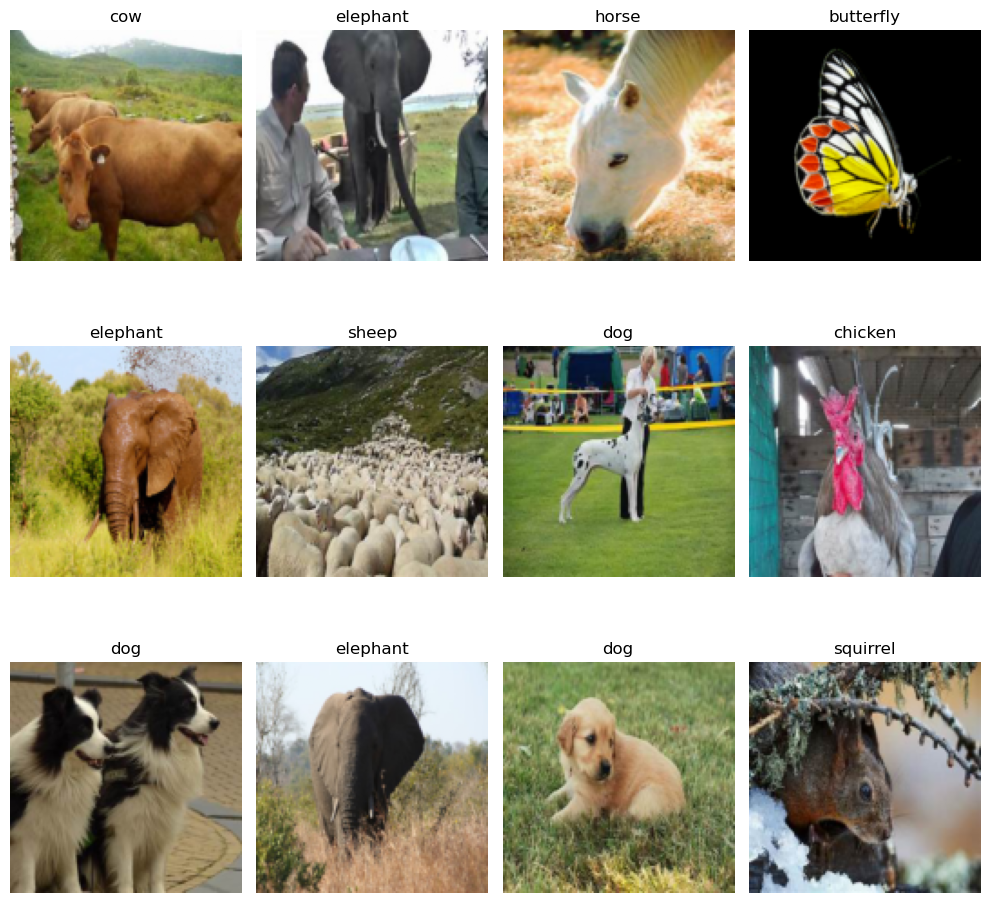

In [2]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


dataset_path = "/Users/arthacharya/Downloads/animal_10/raw-img"

# here i defined transformation
transform = Compose([
    Resize((128, 128)),  # here i am resizing images to 128x128 as you told us on day 2 dec monday class
    ToTensor()           # here i am converting to PyTorch tensors
])

# loading dataset
dataset = ImageFolder(root=dataset_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# here i visualized a batch of images
classes = dataset.classes
images, labels = next(iter(data_loader))

fig, axes = plt.subplots(3, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))  # Convert CHW to HWC
    ax.set_title(classes[labels[i]])
    ax.axis("off")
plt.tight_layout()
plt.show()


In [3]:
import torch
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

In [4]:
# here i defined mean and standard deviation for normalizing RGB channel
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

# here i diid transformations for training data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),                # resize image to 128x128
    transforms.RandomHorizontalFlip(),            # random horizontal flip
    transforms.RandomRotation(10),               # random rotation by 10 degrees
    transforms.RandomCrop(120),                  # randomly crop a portion of the image and resize it to 120x120
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # random color jitter
    transforms.RandomVerticalFlip(),             # random vertical flip
    transforms.ToTensor(),                       # convert to tensor
    transforms.Normalize(means, stds)            # normalize using ImageNet statistics
])



# here i did transformations validation test data resize + normalization
val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

In [5]:
dataset_path = "/Users/arthacharya/Downloads/animal_10/raw-img" 
full_dataset = ImageFolder(root=dataset_path)

In [6]:
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# apply respective transformations
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

In [7]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

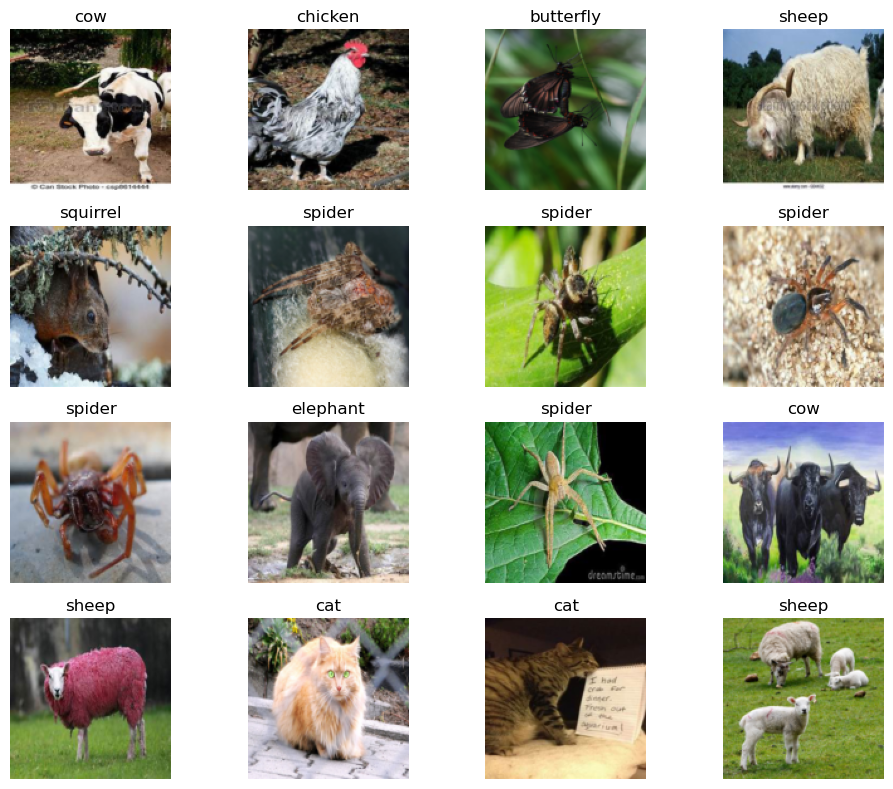

In [8]:
# here i fetched batch of training images
images, labels = next(iter(train_loader))

classes = full_dataset.classes 
fig, axes = plt.subplots(4, 4, figsize=(10, 8))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        img = images[idx].permute(1, 2, 0) * torch.tensor(stds) + torch.tensor(means)
        img = img.clamp(0, 1).numpy()
        ax.imshow(img)
        ax.set_title(classes[labels[idx]])
        ax.axis("off")
plt.tight_layout()
plt.show()

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class AnimalCNN(nn.Module):
    def __init__(self, num_classes):
        super(AnimalCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # conv layer 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # conv layer 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # pooling layer
        
        # here i calculated the input size for the first fcn layer
        self._to_linear = None
        self._calculate_flattened_size()

        self.fc1 = nn.Linear(self._to_linear, 128)  # fcn layer 1
        self.fc2 = nn.Linear(128, num_classes)  # fcn layer 2 output

    def _calculate_flattened_size(self):
        with torch.no_grad():
            # here i did passed dummy input to know the size after convolutions and pooling
            dummy_input = torch.randn(1, 3, 128, 128)  # input size batch size = 1
            x = self.pool(F.relu(self.conv2(F.relu(self.conv1(dummy_input)))))
            self._to_linear = x.numel() 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  #flatten tensor for fcn
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  #output layer
        return x

In [10]:
import torch.optim as optim

# here we have total 10 different animal feature 
num_classes = 10

model = AnimalCNN(num_classes)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)  


In [11]:
def train_model(model, train_loader, val_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # model training
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()  # clear gradients
            outputs = model(images)  # forward pass
            loss = criterion(outputs, labels)  # compute loss
            loss.backward()  # backpropagation
            optimizer.step()  # update weights
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # training accuracy
        train_accuracy = 100 * correct / total

        # validation set
        val_loss, val_accuracy = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


In [12]:
@torch.no_grad()  # disable gradient computation during evaluation
def evaluate_model(model, loader):
    model.eval()  # model evaluation
    total = 0
    correct = 0
    total_loss = 0.0

    for images, labels in loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    accuracy = 100 * correct / total
    return total_loss / len(loader), accuracy


In [13]:
train_model(model, train_loader, val_loader, num_epochs=5)

Epoch 1/5, Train Loss: 1.8707, Train Accuracy: 37.87%, Val Loss: 1.4638, Val Accuracy: 49.56%
Epoch 2/5, Train Loss: 1.0439, Train Accuracy: 65.73%, Val Loss: 1.2754, Val Accuracy: 56.63%
Epoch 3/5, Train Loss: 0.3282, Train Accuracy: 89.63%, Val Loss: 1.5936, Val Accuracy: 57.62%
Epoch 4/5, Train Loss: 0.0666, Train Accuracy: 98.12%, Val Loss: 2.2115, Val Accuracy: 57.16%
Epoch 5/5, Train Loss: 0.0272, Train Accuracy: 99.28%, Val Loss: 2.5717, Val Accuracy: 54.57%


In [14]:
from torchvision import models
from torchvision.models import ResNet18_Weights

pretrained_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# freeze all layers no updates during training
for param in pretrained_model.parameters():
    param.requires_grad = False

# replace the final fully connected layer
num_classes = 10  # define the number of classes for your dataset
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

In [15]:
pretrained_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

#freeze the convolutional base layers
for param in pretrained_model.parameters():
    param.requires_grad = False

#replace the final fcn layer with a custom classifier
num_classes = 10  # Number of classes in your dataset
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

# print the model structure to verify changes
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.fc.parameters(), lr=0.001)  # training the fcn layer

In [17]:
# training function for transfer learning
def train_transfer_model(model, train_loader, val_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()  #model training
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()  # clear gradients
            outputs = model(images)  # forward pass
            loss = criterion(outputs, labels)  # compute loss
            loss.backward()  # backpropagation
            optimizer.step()  # update weights
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # training accuracy
        train_accuracy = 100 * correct / total

        # validation set
        val_loss, val_accuracy = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

In [18]:
# here i fine-tune the pretrained model
train_transfer_model(pretrained_model, train_loader, val_loader, num_epochs=5)

Epoch 1/5, Train Loss: 0.6170, Train Accuracy: 80.83%, Val Loss: 0.3988, Val Accuracy: 87.12%
Epoch 2/5, Train Loss: 0.4409, Train Accuracy: 85.81%, Val Loss: 0.3894, Val Accuracy: 87.20%
Epoch 3/5, Train Loss: 0.4083, Train Accuracy: 86.74%, Val Loss: 0.3912, Val Accuracy: 86.78%
Epoch 4/5, Train Loss: 0.3947, Train Accuracy: 86.98%, Val Loss: 0.3659, Val Accuracy: 87.89%
Epoch 5/5, Train Loss: 0.3775, Train Accuracy: 87.39%, Val Loss: 0.3603, Val Accuracy: 87.89%


In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def evaluate_metrics(model, loader, class_names):
    model.eval()  # here,i set model for evaluation 
    y_true = []
    y_pred = []

    with torch.no_grad():  #disable gradient computation
        for images, labels in loader:
            outputs = model(images)  #here we get model predictions
            _, predicted = torch.max(outputs, 1)  
            y_true.extend(labels.tolist()) 
            y_pred.extend(predicted.tolist())  

    # calculate metrics
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    # print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Precision: 0.8806
Recall: 0.8789
F1 Score: 0.8788


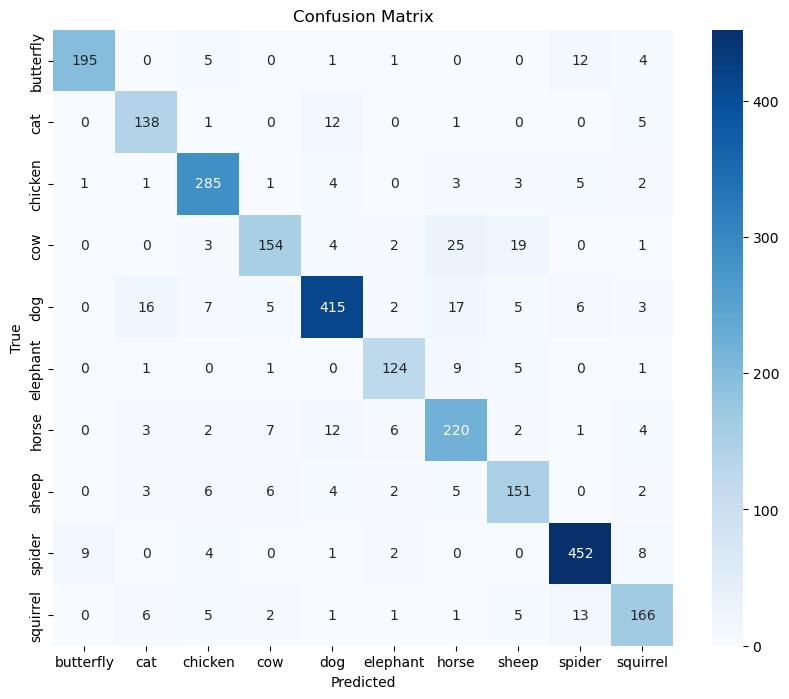

In [23]:
class_names = train_loader.dataset.dataset.classes
evaluate_metrics(pretrained_model, val_loader, class_names)

In [24]:
# Create models directory if it doesn't exist
import os
os.makedirs("models", exist_ok=True)

# Save custom CNN model
torch.save(model.state_dict(), "models/animal_cnn.pth")

# Save pretrained ResNet model
torch.save(pretrained_model.state_dict(), "models/pretrained_resnet.pth")

# Save class names (optional but useful)
import json
with open("models/class_names.json", "w") as f:
    json.dump(dataset.classes, f)